In [ ]:
# 난 사용하지 않았음.
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

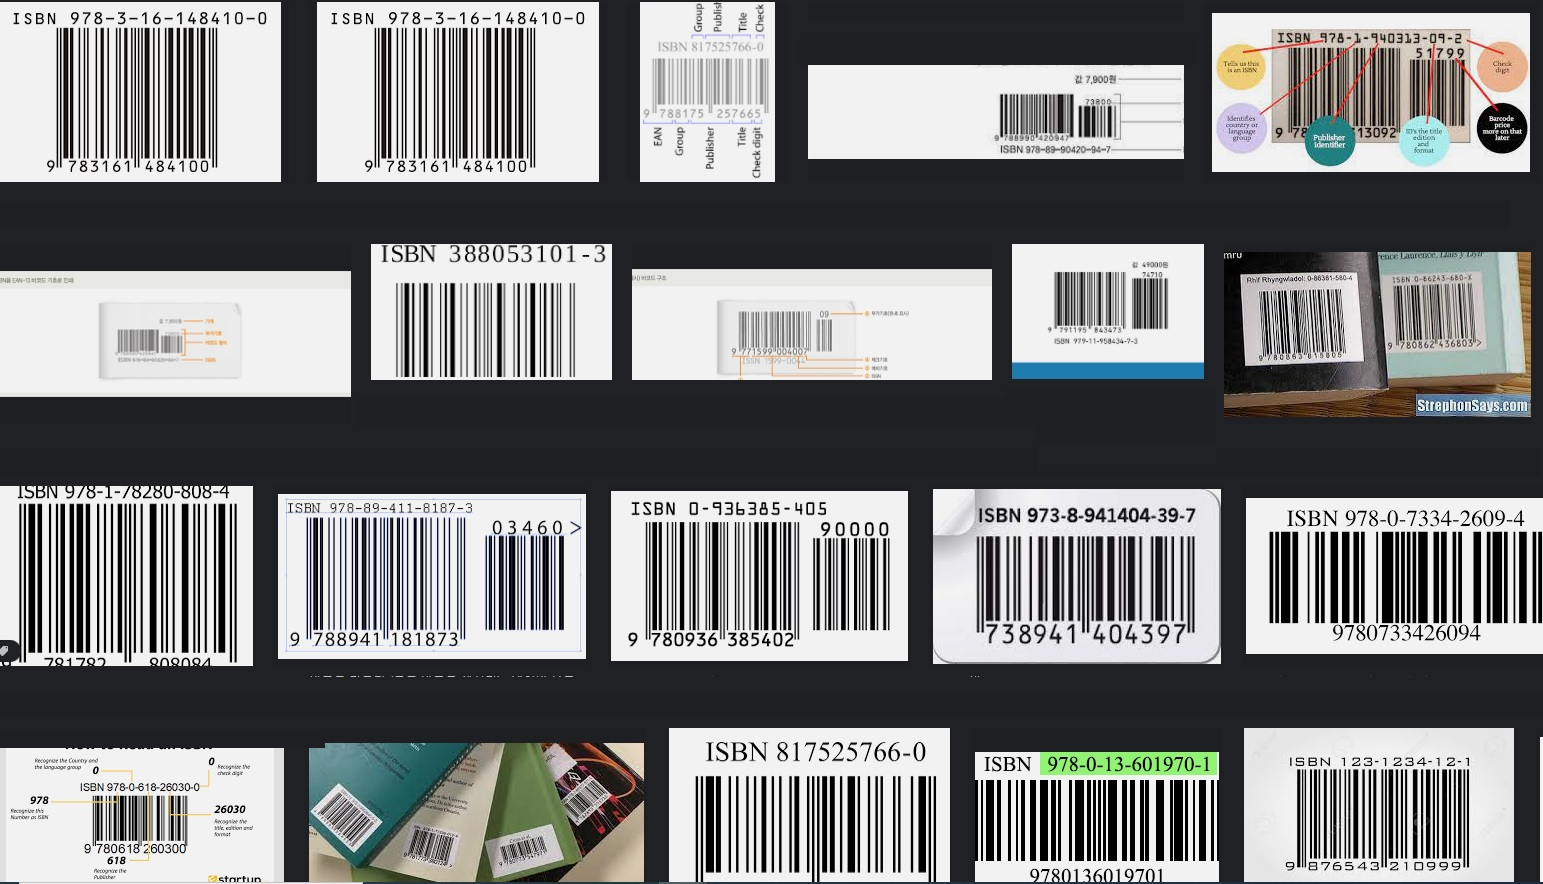

In [75]:
#이미지 불러오는 함수
def get_image():
    file='/content/test/test4.jpg'
    img=cv2.imread(file, cv2.IMREAD_COLOR)
    file= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    cv2_imshow(img)
  
if __name__=='__main__':
    get_image()

In [53]:
#Kako OCR api
import json

import requests
import sys

LIMIT_PX = 1024
LIMIT_BYTE = 1024*1024  # 1MB
LIMIT_BOX = 40


def kakao_ocr_resize(image_path: str):
    """
    ocr detect/recognize api helper
    ocr api의 제약사항이 넘어서는 이미지는 요청 이전에 전처리가 필요.

    pixel 제약사항 초과: resize
    용량 제약사항 초과  : 다른 포맷으로 압축, 이미지 분할 등의 처리 필요. (예제에서 제공하지 않음)

    :param image_path: 이미지파일 경로
    :return:
    """
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    if LIMIT_PX < height or LIMIT_PX < width:
        ratio = float(LIMIT_PX) / max(height, width)
        image = cv2.resize(image, None, fx=ratio, fy=ratio)
        height, width, _ = height, width, _ = image.shape

        # api 사용전에 이미지가 resize된 경우, recognize시 resize된 결과를 사용해야함.
        image_path = "{}_resized.jpg".format(image_path)
        cv2.imwrite(image_path, image)

        return image_path
    return None


def kakao_ocr(image_path: str, appkey: str):
    """
    OCR api request example
    :param image_path: 이미지파일 경로
    :param appkey: 카카오 앱 REST API 키
    """
    API_URL = 'https://dapi.kakao.com/v2/vision/text/ocr'

    headers = {'Authorization': 'KakaoAK {}'.format(appkey)}

    image = cv2.imread(image_path)
    jpeg_image = cv2.imencode(".jpg", image)[1]
    data = jpeg_image.tobytes()


    return requests.post(API_URL, headers=headers, files={"image": data})

In [81]:
import re

def main():
    if len(sys.argv) != 3:
        print("Please run with args: $ python example.py /path/to/image appkey")
    image_path, appkey = '/content/test/test4.jpg', 'RestAPIKey'

    resize_impath = kakao_ocr_resize(image_path)
    if resize_impath is not None:
        image_path = resize_impath
        print("원본 대신 리사이즈된 이미지를 사용합니다.")

    #카카오 API에서 범위, 인식한 글씨 받기
    output = kakao_ocr(image_path, appkey).json()
    outputdata = json.dumps(output, ensure_ascii=False,sort_keys=True, indent=2)
    #print("[OCR] output:\n{}\n".format(outputdata))

    #받은 데이터 array로 변환
    outputdata = json.loads(outputdata)
    #print(str(outputdata))

    if 'result' in outputdata :
      for i in range(len(outputdata['result'])):
        word = outputdata['result'][i]['recognition_words'][0]
        
        x = outputdata['result'][i]['boxes'][0][0]
        y = outputdata['result'][i]['boxes'][0][1]
        w = outputdata['result'][i]['boxes'][1][0] - outputdata['result'][i]['boxes'][0][0]
        h = outputdata['result'][i]['boxes'][2][1] - outputdata['result'][i]['boxes'][0][1]
        
        word = word.strip()

        # 원본 이미지
        org_img = cv2.imread(image_path)

        # 자른 이미지
        cut_img = org_img[y:y+h, x:x+w]

        # 자른 이미지 출력
        cv2_imshow(cut_img)

        if word.find('ISBN') != -1:
          if re.search('\d', word) == None:
            word =  'ISBN : '+ outputdata['result'][i + 1]['recognition_words'][0]
            print(word)
          else :
            print(word)

    else:
       print('사진 인식 실패')

if __name__ == "__main__":
    main()

원본 대신 리사이즈된 이미지를 사용합니다.


ISBN : 978-3-16-148410-0


ISBN : 978-3-16-148410-0


ISBN : 978-


ISBN 817525766-0


ISBN : 388053101-3


ISBN : 978-1


ISBN : 0-936385-405


ISBN : 973-8-941404-39-7


ISBN : T978-0-7334-2


ISBN : 817525766-0


ISBN : 978-0-13-601970-1


ISBN : 123-1234-12


ISBN : 975-0-018-20030-0
